In [0]:
# Importing dataset
import urllib.request
import _pickle as pickle
import gzip
import os
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

path = 'http://deeplearning.net/data/mnist'
mnist_filename_all = 'mnist.pkl'
local_filename = os.path.join("./", mnist_filename_all)
urllib.request.urlretrieve(
    "{}/{}.gz".format(path,mnist_filename_all), local_filename+'.gz')
tr,va,te = pickle.load(gzip.open(local_filename+'.gz','r'), encoding='latin1')
np.save(open(local_filename+'.npy','wb'), (tr,va,te))

In [0]:
# Split dataset

validRatio = 0.1
mnist_npy = np.load("mnist.pkl.npy")
train_images = mnist_npy[0,0]
train_labels = mnist_npy[0,1]
valid_images = mnist_npy[1,0]
valid_labels = mnist_npy[1,1]
test_images = mnist_npy[2,0]
test_labels = mnist_npy[2,1]

def one_hot_vectorize(vector):
  one_hot_matrix = np.zeros((vector.shape[0], np.max(vector) + 1))
  one_hot_matrix[np.arange(vector.shape[0]), vector] = 1
  return one_hot_matrix

train_labels = one_hot_vectorize(train_labels)
valid_labels = one_hot_vectorize(valid_labels)
test_labels = one_hot_vectorize(test_labels)

In [0]:
# Building basic modules
import numpy as np
from abc import ABC, abstractmethod
from enum import Enum

class Function(ABC):
  @abstractmethod
  def fprop(self, input):
    pass
  
  @abstractmethod
  def bprop(self, grads_ouput):
    pass
  
class InitMethod(Enum):
  ZERO = 1
  NORMAL = 2
  GLOROT = 3
  XAVIER = 4
  
class LinearLayer(Function):
  def __init__(self, in_n_nodes, out_n_nodes, init_method=InitMethod.GLOROT):
    self.in_n_nodes = in_n_nodes
    self.out_n_nodes = out_n_nodes
    self.init_method = init_method
    
  def reset(self):
    if self.init_method == InitMethod.ZERO:
      self.weights = np.zeros((self.in_n_nodes, self.out_n_nodes))
    elif self.init_method == InitMethod.NORMAL:
      self.weights = np.random.normal(size=(self.in_n_nodes, self.out_n_nodes))
    elif self.init_method == InitMethod.GLOROT:
      bound = np.sqrt(6.0/(1.0*(self.in_n_nodes + self.out_n_nodes)))  
      self.weights = np.random.uniform(-bound, bound, size=(self.in_n_nodes, self.out_n_nodes))
    elif self.init_method == InitMethod.XAVIER:
      bound = 1/np.sqrt(self.in_n_nodes)
      self.weights = np.random.uniform(-bound, bound, size=(self.in_n_nodes, self.out_n_nodes))
    self.bias = np.zeros(self.out_n_nodes)
    self.iterations = 0
    self.zero_grads()
  
  def zero_grads(self):
    self.grad_weights = np.zeros_like(self.weights)
    self.grad_bias = np.zeros_like(self.bias)
    self.grad_input = np.zeros((1, self.in_n_nodes))
  
  def fprop(self, input):
    self.input = input
    output = self.input.dot(self.weights) + self.bias
    assert(output.shape == (self.input.shape[0], self.out_n_nodes))
    return output
  
  def bprop(self, grad_output):
    self.grad_weights = (self.input.T.dot(grad_output)) / self.input.shape[0]
    assert(self.grad_weights.shape == self.weights.shape)

    self.grad_bias = np.mean(grad_output, axis=0)
    assert(self.grad_bias.shape == self.bias.shape)

    self.grad_input = grad_output.dot(self.weights.T)
    assert(self.grad_input.shape == self.input.shape)

    return self.grad_input
 
  def update(self, learning_rate):
    self.weights -= learning_rate * self.grad_weights
    self.bias -= learning_rate * self.grad_bias
  
class ReLU(Function):
  def fprop(self, input):
    self.input = input
    output = np.maximum(self.input, 0)
    assert(output.shape == self.input.shape)
    return output
  
  def bprop(self, grad_output):
    grad_input = (self.input > 0) * grad_output
    return grad_input

class Softmax():
  @staticmethod
  def fprop(input):
    exp = np.exp(input - input.max(axis=1, keepdims=True))
    output = exp / exp.sum(axis=1, keepdims=True)
    return output
  
class CrossEntropyLoss(Function):
  def fprop(self, input, target):
    self.epsilon = 1e-10
    self.target = target
    self.input = Softmax.fprop(input)
    assert(np.allclose(self.input.sum(axis=1, keepdims=True), np.ones_like(self.target.shape[0])))
    logs = -np.log(self.input[np.arange(input.shape[0]), self.target.argmax(axis=1)]+self.epsilon)
    self.losses = logs.sum()
    return (self.losses) / input.shape[0]

  def bprop(self):
    self.grad_input = copy.deepcopy(self.input)
    self.grad_input[np.arange(self.input.shape[0]), self.target.argmax(axis=1)] -= 1
    return self.grad_input

In [0]:
# Building NN
import copy

class NN(object):
  def __init__(self,hidden_dims=(2,2), init_method=InitMethod.GLOROT):
    dims = (784, *hidden_dims)
    self.fcs = []
    self.layers = []
    for i_dim in range(len(dims) - 1):
      fc = LinearLayer(dims[i_dim], dims[i_dim + 1], init_method)
      relu = ReLU()
      self.fcs.append(fc)
      self.layers.append(fc)
      self.layers.append(relu)

    last_linear = LinearLayer(dims[-1], 10, init_method)
    self.fcs.append(last_linear)
    self.layers.append(last_linear)
    
    self.lossFunc = CrossEntropyLoss()
    
    self.initialize_weights()

  def initialize_weights(self):
    for fc in self.fcs:
      fc.reset()
  
  def zero_grads(self):
    for fc in self.fcs:
      fc.zero_grads()

  def forward(self, input):
    x = input
    for layer in self.layers:
      x = layer.fprop(x)
    return x
    
  def loss(self, prediction, labels):
    return self.lossFunc.fprop(prediction, labels)
    
  def softmax(self,input):
    output = Softmax.fprop(input)
    return output

  def backward(self):
    grad = self.lossFunc.bprop()
    for layer in reversed(self.layers):
      grad = layer.bprop(grad)
  
  def update(self, learning_rate):
    for fc in self.fcs:
      fc.update(learning_rate)

In [0]:
def finite_gradient_check(mlp, x, y, k=None, i=None):
  if not k:
    k = np.random.randint(1, 5)
  if not i:
    i = np.random.randint(0, 5)
  eps = 1/float(k*10**i)

  weights = copy.deepcopy(mlp.fcs[1].weights)
  n_weights = min(10, weights.shape[1])
  estimated_grads = np.zeros_like(weights[:n_weights])
  
  for i_idx in range(n_weights):
    for j_idx in range(weights.shape[0]):
      mlp.fcs[1].weights[i_idx,j_idx] += eps

      output = mlp.forward(x)
      loss_peps = mlp.loss(output, y)

      mlp.fcs[1].weights[i_idx,j_idx] -= 2*eps
      
      output = mlp.forward(x)
      loss_neps = mlp.loss(output, y)
      
      estimated_grads[i_idx, j_idx] = (loss_peps - loss_neps)/(2.0*eps)
      
  mlp.fcs[1].weights = weights
  output = mlp.forward(x)
  loss = mlp.loss(output, y)
  mlp.backward()
#   print("Gradient estimé")
#   print(estimated_grads)

#   print("Gradient par backpropagation")
#   print(mlp.fcs[1].grad_weights)
  return estimated_grads,mlp.fcs[1].grad_weights

[2e-06, 2.5e-06, 3.3333333333333333e-06, 5e-06, 1e-05, 2e-05, 2.5e-05, 3.3333333333333335e-05, 5e-05, 0.0001, 0.0002, 0.00025, 0.0003333333333333333, 0.0005, 0.001]
[3.166458802106309e-08, 3.963598934481061e-08, 5.271441656795606e-08, 7.907111117949617e-08, 1.5818560391428482e-07, 3.162813626209071e-07, 3.9533368285937787e-07, 5.270816287455959e-07, 7.905997249785246e-07, 1.5811384705549658e-06, 3.1622115208157497e-06, 3.9527458255000925e-06, 5.270300113394133e-06, 7.905398253085782e-06, 1.5810600967738897e-05]


Text(0, 0.5, 'Maxium gradient difference')

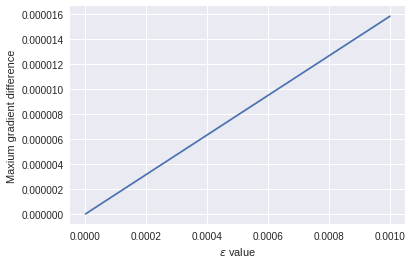

In [0]:
import matplotlib.axes as ax
np.random.seed(6)   # Adjust seed if no straight line is shown in the graph
mlp = NN((2,2),init_method=InitMethod.GLOROT)
maxDiff = []
xaxis = []

for i in range(3,6):
  for k in range(1,6):
    estimatedGrads, bpropGrads = finite_gradient_check(mlp, train_images[0].reshape(1,-1), train_labels[0].reshape(1,-1), k, i)
    maxDiff.append(np.amax(np.absolute(estimatedGrads-bpropGrads)))
    xaxis.append(1/float(k*10**i))

xaxis.reverse()
maxDiff.reverse()

plt.plot(xaxis,maxDiff)

plt.xlabel('$\epsilon$ value')
plt.ylabel('Maxium gradient difference')


In [0]:
def batchLoader(dataset, batchSize):
  images, labels = dataset
  batches = []
  eof = False
  i = 0
  while eof == False:
    if (i+batchSize)>= len(images):
      batches.append((images[i:],labels[i:]))
      eof = True
    else:
      batches.append((images[i:i+batchSize],labels[i:i+batchSize]))
    i += batchSize
  return batches

In [0]:
def trainEpoch(mlp, dataset, batchSize, learningRate):
  batches = batchLoader(dataset,batchSize)
  loss_avg = 0
  acc_avg = 0
  for i, (images, labels) in enumerate(batches):
    output = mlp.forward(images.reshape(len(images), -1))
    loss = mlp.loss(output,labels)
    loss_avg += loss
    mlp.backward()
    mlp.update(learningRate)
    mlp.zero_grads()
    correct = (np.argmax(output, axis=1) == np.argmax(labels, axis=1)).sum()
    acc_avg += correct
    if (i+1) % 100 == 0:
      print('Step [{}/{}], Loss: {:.4f}({:.4f}), Accuracy: {:.3f}({:.3f})' 
                   .format(i+1, len(batches), loss, loss_avg / (i + 1),
                           correct * 100 / batchSize,
                           acc_avg * 100 / ((i + 1) * batchSize)))
  return loss_avg / (i + 1), acc_avg * 100 / ((i + 1) * batchSize)

In [0]:
def modelEval(mlp, dataset):
  images, labels = dataset
  output = mlp.forward(images.reshape(len(images),-1))
  loss = np.mean(mlp.loss(output,labels))
  rightPred = 0
  total = 0
  for i,example in enumerate(output):
    if np.argmax(example)==np.argmax(labels[i]):
      rightPred += 1
    total += 1
  print('Validation Loss: {:.4f}, Accuracy: {:.4f} '.format(loss, rightPred * 100/total))
  return loss, rightPred/total

In [0]:
# ZERO INIT
mlp = NN((512,512), init_method=InitMethod.ZERO)
losses_zero_init = []
for epoch in range(10):
  print("Epoch [{}/10]".format(epoch))
  loss = trainEpoch(mlp, (train_images, train_labels), 20, 0.0005)
  losses_zero_init.append(loss)

Epoch [0/10]
Step [100/2500], Loss: 2.3026(2.3026), Accuracy: 10.000(10.200)
Step [200/2500], Loss: 2.3026(2.3026), Accuracy: 5.000(10.375)
Step [300/2500], Loss: 2.3025(2.3026), Accuracy: 10.000(10.700)


KeyboardInterrupt: ignored

In [0]:
# NORMAL INIT
mlp = NN((512,512), init_method=InitMethod.NORMAL)
losses_normal_init = []
for epoch in range(10):
  print("Epoch [{}/10]".format(epoch))
  loss = trainEpoch(mlp, (train_images, train_labels), 20, 0.0005)
  losses_normal_init.append(loss)

Epoch [0/10]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log


Step [100/2500], Loss: inf(inf), Accuracy: 65.000(44.300)


KeyboardInterrupt: ignored

In [0]:
# GLOROT INIT
mlp = NN((512,512), init_method=InitMethod.GLOROT)
losses_glorot_init = []
for epoch in range(10):
  print("Epoch [{}/10]".format(epoch))
  loss = trainEpoch(mlp, (train_images, train_labels), 20, 0.0005)
  losses_glorot_init.append(loss)

0.06804138174397717
<class 'numpy.float64'>
0.07654655446197431
<class 'numpy.float64'>
0.10721125348377948
<class 'numpy.float64'>
Epoch [0/10]
Step [100/2500], Loss: 2.1735(2.2942), Accuracy: 25.000(15.700)
Step [200/2500], Loss: 2.2461(2.2693), Accuracy: 20.000(19.525)
Step [300/2500], Loss: 2.1244(2.2484), Accuracy: 50.000(22.467)
Step [400/2500], Loss: 2.0739(2.2280), Accuracy: 40.000(24.400)
Step [500/2500], Loss: 2.0189(2.2053), Accuracy: 45.000(26.850)
Step [600/2500], Loss: 2.0344(2.1851), Accuracy: 40.000(28.992)
Step [700/2500], Loss: 2.1765(2.1674), Accuracy: 20.000(30.729)
Step [800/2500], Loss: 2.0015(2.1513), Accuracy: 60.000(32.513)
Step [900/2500], Loss: 1.9781(2.1356), Accuracy: 55.000(34.389)
Step [1000/2500], Loss: 1.9095(2.1159), Accuracy: 45.000(36.745)
Step [1100/2500], Loss: 1.8079(2.0964), Accuracy: 70.000(38.891)
Step [1200/2500], Loss: 1.7971(2.0785), Accuracy: 60.000(40.700)
Step [1300/2500], Loss: 1.7488(2.0598), Accuracy: 80.000(42.515)
Step [1400/2500], L

In [0]:
# XAVIER INIT
mlp = NN((512,512), init_method=InitMethod.XAVIER)
losses_xavier_init = []
for epoch in range(10):
  print("Epoch [{}/10]".format(epoch))
  loss = trainEpoch(mlp, (train_images, train_labels), 20, 0.0005)
  losses_xavier_init.append(loss)

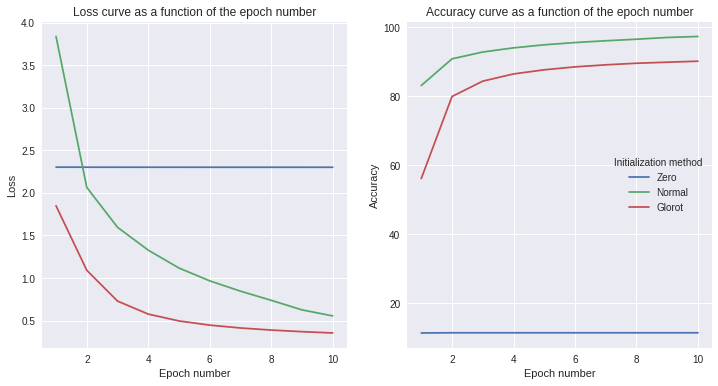

In [0]:
#Plotting losses
x = np.arange(1, len(losses_glorot_init)+1)
plt.subplot(1,2,1)
plt.plot(x,[losses_zero_init[i][0] for i in range(len(losses_zero_init))])
plt.plot(x,[losses_normal_init[i][0] for i in range(len(losses_normal_init))])
plt.plot(x,[losses_glorot_init[i][0] for i in range(len(losses_glorot_init))])

plt.title("Loss curve as a function of the epoch number")
plt.xlabel("Epoch number")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(x,[losses_zero_init[i][1] for i in range(len(losses_zero_init))])
plt.plot(x,[losses_normal_init[i][1] for i in range(len(losses_normal_init))])
plt.plot(x,[losses_glorot_init[i][1] for i in range(len(losses_glorot_init))])

plt.title("Accuracy curve as a function of the epoch number")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend(["Zero","Normal","Glorot"], title = "Initialization method")

fig = plt.gcf()
fig.set_size_inches(12, 6)

Epoch [1/30]
Step [100/391], Loss: 0.6355(1.0863), Accuracy: 81.250(75.445)
Step [200/391], Loss: 0.3446(0.7758), Accuracy: 92.188(81.395)
Step [300/391], Loss: 0.3445(0.6444), Accuracy: 88.281(83.919)
Validation Loss: 0.3119, Accuracy: 91.0400 
Epoch [2/30]
Step [100/391], Loss: 0.3682(0.2925), Accuracy: 92.188(91.836)
Step [200/391], Loss: 0.2797(0.2896), Accuracy: 92.188(91.824)
Step [300/391], Loss: 0.2621(0.2856), Accuracy: 90.625(91.878)
Validation Loss: 0.2443, Accuracy: 93.0100 
Epoch [3/30]
Step [100/391], Loss: 0.3084(0.2310), Accuracy: 93.750(93.594)
Step [200/391], Loss: 0.2507(0.2301), Accuracy: 92.188(93.496)
Step [300/391], Loss: 0.2278(0.2288), Accuracy: 94.531(93.560)
Validation Loss: 0.2024, Accuracy: 94.3400 
Epoch [4/30]
Step [100/391], Loss: 0.2716(0.1915), Accuracy: 95.312(94.617)
Step [200/391], Loss: 0.2282(0.1908), Accuracy: 92.969(94.578)
Step [300/391], Loss: 0.2041(0.1909), Accuracy: 94.531(94.594)
Validation Loss: 0.1741, Accuracy: 95.2600 
Epoch [5/30]
Ste

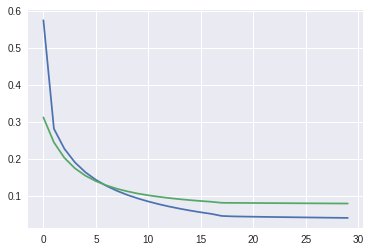

In [0]:
# test main
model = NN((512,512), init_method=InitMethod.GLOROT)
trainDataset = [train_images,train_labels]
validDataset = [valid_images,valid_labels]
testDataset = [test_images,test_labels]
nbEpoch = 30
batchSize = 128
learningRate = 0.05

train_loss = []
train_acc = []
valid_loss = []
valid_accuracy = []

for epoch in range(1,nbEpoch+1):
  print("Epoch [{}/{}]".format(epoch, nbEpoch))
  # train
  loss, acc = trainEpoch(model, trainDataset, batchSize, learningRate)
  train_loss.append(loss)
  train_acc.append(acc)
  
  # valid
  loss, acc = modelEval(model, validDataset)
  valid_loss.append(loss)
  if epoch % 17 == 0:#(epoch>1 and np.abs(acc-valid_accuracy[-1])<0.01):
    learningRate /=10
    print('New learning rate : {}'.format(learningRate))
  valid_accuracy.append(acc)
  
# test
print('Test performances: \n')
loss, acc = modelEval(model, testDataset)

x = np.arange(len(train_loss))
plt.plot(x,train_loss)
plt.plot(x,valid_loss)

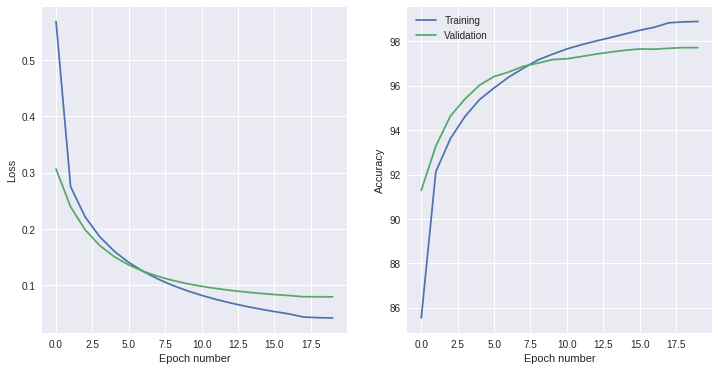

In [0]:
x = np.arange(len(train_loss))
plt.subplot(1,2,1)
plt.plot(x,train_loss)
plt.plot(x,valid_loss)
plt.xlabel("Epoch number")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(x,train_acc)
plt.plot(x,100*np.asarray(valid_accuracy))
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")

plt.legend(["Training","Validation"])

fig = plt.gcf()
fig.set_size_inches(12, 6)